## Estimating lifespan normative models

Import the required libraries

In [1]:
# we need to be in the CPC_ML_tutorial folder when we import the libraries in the code block below,
# because there is a function called nm_utils that is in this folder that we need to import
import os

In [2]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
import random as rd 
from random import uniform, random, choice, sample

from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
from nm_utils import calibration_descriptives, remove_bad_subjects, load_2d

Now, we configure the locations in which the data are stored. 

**Notes:** 
- The data are assumed to be in CSV format and will be loaded as pandas dataframes
- Generally the raw data will be in a different location to the analysis
- The data can have arbitrary columns but some are required by the script, i.e. 'age', 'sex' and 'site', plus the phenotypes you wish to estimate (see below)

In [29]:
# where the raw data are stored
#data_dir = '/Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/volume_inputs'
data_dir = '/Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/area_inputs'

# where the analysis takes place
root_dir = '/Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results'

# when testing for control group/area
out_dir = os.path.join(root_dir, 'area')

# when testing for control group/volume
#out_dir = os.path.join(root_dir, 'volume')

# create the output directory if it does not already exist
os.makedirs(out_dir, exist_ok=True)

Now we load the data. 

We will load one pandas dataframe for the training set and one dataframe for the test set. We also configure a list of site ids.

In [30]:
df_tr = pd.read_csv(os.path.join(data_dir,'train_data.csv'), index_col=0)

# running for control
df_te = pd.read_csv(os.path.join(data_dir,'test_data.csv'), index_col=0)

# extract a list of unique site ids from the training set
site_ids =  sorted(set(df_tr['site'].to_list()))

In [31]:
print(list(df_te.columns))

['ID_MTL', 'age', 'sex', 'site', 'sitenum', 'total_area', 'avg_en', 'lh_bankssts_area_z_scored', 'lh_caudalanteriorcingulate_area_z_scored', 'lh_caudalmiddlefrontal_area_z_scored', 'lh_cuneus_area_z_scored', 'lh_entorhinal_area_z_scored', 'lh_fusiform_area_z_scored', 'lh_inferiorparietal_area_z_scored', 'lh_inferiortemporal_area_z_scored', 'lh_isthmuscingulate_area_z_scored', 'lh_lateraloccipital_area_z_scored', 'lh_lateralorbitofrontal_area_z_scored', 'lh_lingual_area_z_scored', 'lh_medialorbitofrontal_area_z_scored', 'lh_middletemporal_area_z_scored', 'lh_parahippocampal_area_z_scored', 'lh_paracentral_area_z_scored', 'lh_parsopercularis_area_z_scored', 'lh_parsorbitalis_area_z_scored', 'lh_parstriangularis_area_z_scored', 'lh_pericalcarine_area_z_scored', 'lh_postcentral_area_z_scored', 'lh_posteriorcingulate_area_z_scored', 'lh_precentral_area_z_scored', 'lh_precuneus_area_z_scored', 'lh_rostralanteriorcingulate_area_z_scored', 'lh_rostralmiddlefrontal_area_z_scored', 'lh_superiorf

In [32]:
df_tr

,ID_MTL,age,sex,site,sitenum,total_area,avg_en,lh_bankssts_area_z_scored,lh_caudalanteriorcingulate_area_z_scored,lh_caudalmiddlefrontal_area_z_scored,...,rh_rostralanteriorcingulate_area_z_scored,rh_rostralmiddlefrontal_area_z_scored,rh_superiorfrontal_area_z_scored,rh_superiorparietal_area_z_scored,rh_superiortemporal_area_z_scored,rh_supramarginal_area_z_scored,rh_frontalpole_area_z_scored,rh_temporalpole_area_z_scored,rh_transversetemporal_area_z_scored,rh_insula_area_z_scored
1,1000901,62.973118,0,S11025,11025,-1.147716,-22,-0.465357,-0.593618,-1.812882,...,-0.231898,-1.321751,-0.625924,-1.560009,-0.492773,-1.086300,-0.909904,-1.872243,-0.495359,-0.844564
2,1001344,55.529570,1,S11026,11026,0.661899,-24,-0.185956,0.133942,0.739836,...,-0.631617,0.273545,0.597999,1.830577,0.575002,1.290126,-1.124262,0.408217,-0.001161,0.111187
3,1001784,64.400538,0,S11025,11025,0.566677,-35,-0.312956,-0.035087,-0.299937,...,-0.751533,-0.781922,-0.260398,0.659544,0.708795,0.846242,1.421237,-0.061289,0.719546,0.545313
4,1001969,56.900538,1,S11025,11025,-0.888106,-27,-0.681257,-1.277083,0.338996,...,-1.159247,-1.181701,-1.018570,-1.179741,-0.232905,-0.442766,-0.990288,-0.949998,0.204755,-0.861391
5,1002017,68.040323,1,S11025,11025,-0.128898,-40,-0.230406,0.207433,0.176249,...,-1.007353,-0.506915,0.790195,1.023900,0.760254,0.483769,1.448032,1.162781,0.390080,-0.215249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,6024210,63.959677,1,S11025,11025,-1.201568,-42,-0.452657,-1.482857,-1.189018,...,-1.383089,-0.872318,-1.035078,-0.126448,-1.110281,-0.886650,-1.928103,-1.134447,-0.021752,-1.002734
9994,6024559,69.053763,0,S11025,11025,-1.170235,-20,-0.370106,-1.078657,-0.432546,...,-1.510999,-0.759004,-0.974943,-0.043712,-1.390732,-0.590081,-1.392209,-1.520113,-1.133699,-1.803680
9995,6024774,60.034946,0,S11025,11025,0.255724,-38,-1.005108,-0.549523,0.143097,...,-1.039331,0.812101,0.467117,-0.392158,0.996966,-0.109368,0.403038,-0.832621,0.163572,0.905402
9996,6025185,67.701613,1,S11025,11025,-0.993365,-40,-0.459007,-1.468159,-0.206508,...,-0.175938,0.287550,-1.050406,-0.229868,-1.516807,-0.937047,0.563806,-0.396651,-0.536543,-0.905140


In [8]:
#df_te = pd.get_dummies(df_te, columns=['sex'])

In [9]:
#df_tr = pd.get_dummies(df_tr, columns=['sex'])

In [33]:
site_ids =  sorted(set(df_tr['site'].to_list()))

### Configure which models to fit

Next, we load the image derived phenotypes (IDPs) which we will process in this analysis. This is effectively just a list of columns in your dataframe. Here we estimate normative models for the left hemisphere, right hemisphere and cortical structures.

In [34]:
# we choose here to process all idps. 

idp_ids = list(df_tr.loc[:,df_tr.columns.str.endswith('_area_z_scored')].columns)
#idp_ids = list(df_tr.loc[:,df_tr.columns.str.endswith('_volume_z_scored')].columns)

In [35]:
print(idp_ids)

['lh_bankssts_area_z_scored', 'lh_caudalanteriorcingulate_area_z_scored', 'lh_caudalmiddlefrontal_area_z_scored', 'lh_cuneus_area_z_scored', 'lh_entorhinal_area_z_scored', 'lh_fusiform_area_z_scored', 'lh_inferiorparietal_area_z_scored', 'lh_inferiortemporal_area_z_scored', 'lh_isthmuscingulate_area_z_scored', 'lh_lateraloccipital_area_z_scored', 'lh_lateralorbitofrontal_area_z_scored', 'lh_lingual_area_z_scored', 'lh_medialorbitofrontal_area_z_scored', 'lh_middletemporal_area_z_scored', 'lh_parahippocampal_area_z_scored', 'lh_paracentral_area_z_scored', 'lh_parsopercularis_area_z_scored', 'lh_parsorbitalis_area_z_scored', 'lh_parstriangularis_area_z_scored', 'lh_pericalcarine_area_z_scored', 'lh_postcentral_area_z_scored', 'lh_posteriorcingulate_area_z_scored', 'lh_precentral_area_z_scored', 'lh_precuneus_area_z_scored', 'lh_rostralanteriorcingulate_area_z_scored', 'lh_rostralmiddlefrontal_area_z_scored', 'lh_superiorfrontal_area_z_scored', 'lh_superiorparietal_area_z_scored', 'lh_sup

### Configure model parameters

Now, we configure some parameters for the regression model we use to fit the normative model. Here we will use a 'warped' Bayesian linear regression model. To model non-Gaussianity, we select a sin arcsinh warp and to model non-linearity, we stick with the default value for the basis expansion (a cubic b-spline basis set with 5 knot points). Since we are sticking with the default value, we do not need to specify any parameters for this, but we do need to specify the limits. We choose to pad the input by a few years either side of the input range. We will also set a couple of options that control the estimation of the model

For further details about the likelihood warping approach, see [Fraza et al 2021](https://www.biorxiv.org/content/10.1101/2021.04.05.438429v1).

In [36]:
# check the min & max age of the dataset, use this info to update the xmin & xmax variables in the code block below. 
df_tr['age'].describe()

count    9997.000000
mean       63.701546
std         7.549301
min        45.913978
25%        57.830645
50%        64.322581
75%        69.629032
max        80.543011
Name: age, dtype: float64

In [38]:
# which data columns do we wish to use as covariates? 
# You could add additional covariates from your own dataset here that you wish to use as predictors.
# However, for this tutorial today we will keep it simple and just use age & sex. 
# Maybe discuss with your partner ideas you have for other covariates you would like to include.

#cols_cov = ['age','sex_0', 'sex_1', 'total_volume'] #, 'sitenum_11025', 'sitenum_11026', 'sitenum_11027']
cols_cov = ['age', 'sex'] #, 'total_area'] #, 'sitenum_11025', 'sitenum_11026', 'sitenum_11027']

# which warping function to use? We can set this to None in order to fit a vanilla Gaussian noise model
warp =  'WarpSinArcsinh'

# limits for cubic B-spline basis 
# check the min & max ages of the dataframes, add 5 to the max 
# and subtract 5 from the min and adjust these variables accordingly
xmin = 40# set this variable
xmax = 85# set this variable

# Do we want to force the model to be refit every time? 
# When training normative model from scratch like we are doing in this notebook (not re-using a pre-trained model), 
# this variable should be = True
force_refit = True 

# Absolute Z treshold above which a sample is considered to be an outlier (without fitting any model)
outlier_thresh = 7

### Fit the models

Now we fit the models. This involves looping over the IDPs we have selected. We will use a module from PCNtoolkit to set up the design matrices, containing the covariates, fixed effects for site and nonlinear basis expansion. 

### Compute error metrics

In this section we compute the following error metrics for all IDPs (all evaluated on the test set):

- Negative log likelihood (NLL)
- Explained variance (EV)
- Mean standardized log loss (MSLL)
- Bayesian information Criteria (BIC)
- Skew and Kurtosis of the Z-distribution

In [40]:
for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
   
    # set output dir 
    idp_dir = os.path.join(out_dir, idp)
    os.makedirs(os.path.join(idp_dir), exist_ok=True)
    os.chdir(idp_dir)
    
    # extract the response variables for training and test set
    y_tr = df_tr[idp].to_numpy() 
    y_te = df_te[idp].to_numpy()
    
    # remove gross outliers and implausible values
    ## not enough individuals in the dataset to do so
    #yz_tr = (y_tr - np.mean(y_tr)) / np.std(y_tr)
    #yz_te = (y_te - np.mean(y_te)) / np.std(y_te)
    #nz_tr = np.bitwise_and(np.abs(yz_tr) < outlier_thresh, y_tr > 0)
    #nz_te = np.bitwise_and(np.abs(yz_te) < outlier_thresh, y_te > 0)
    #y_tr = y_tr[nz_tr]
    #y_te = y_te[nz_te]
    
    # write out the response variables for training and test
    resp_file_tr = os.path.join(idp_dir, 'resp_tr.txt')
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt') 
    np.savetxt(resp_file_tr, y_tr)
    np.savetxt(resp_file_te, y_te)
        
    # configure the design matrix
    X_tr = create_design_matrix(df_tr[cols_cov], 
                                site_ids = df_tr['site'],
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)
    X_te = create_design_matrix(df_te[cols_cov], 
                                site_ids = df_te['site'], 
                                all_sites=site_ids,
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)

    # configure and save the covariates
    cov_file_tr = os.path.join(idp_dir, 'cov_bspline_tr.txt')
    cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
    np.savetxt(cov_file_tr, X_tr)
    np.savetxt(cov_file_te, X_te)

    print('Estimating the normative model...')
    estimate(cov_file_tr, resp_file_tr, testresp=resp_file_te, 
             testcov=cov_file_te, alg='blr', optimizer = 'l-bfgs-b', 
             savemodel=True, warp=warp, warp_reparam=True)
    suffix = 'estimate'

Running IDP 0 lh_bankssts_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/lh_bankssts_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 1 lh_caudalanteriorcingulate_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/lh_caudalanteriorcingulate_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 2 lh_caudalmiddlefrontal_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/lh_caudalmiddlefrontal_area_z_scored/resp_tr.txt
Estimating model

/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.8177e-52): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.26407e-52): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.10575e-52): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.42955e-52): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=Fals

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 5 lh_fusiform_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/lh_fusiform_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.11662e-167): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.53454e-167): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.47085e-167): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.75991e-167): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 6 lh_inferiorparietal_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/lh_inferiorparietal_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.64234e-171): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.48605e-171): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.00595e-171): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.81506e-171): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 7 lh_inferiortemporal_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/lh_inferiortemporal_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 8 lh_isthmuscingulate_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/lh_isthmuscingulate_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 9 lh_lateraloccipital_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/

/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:127: RuntimeWarning: divide by zero encountered in true_divide
  beta = beta/(delta**2)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:185: RuntimeWarning: invalid value encountered in multiply
  XtLambda_n = X.T*self.lambda_n_vec


/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.21285e-136): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.33613e-136): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.12526e-135): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.01818e-135): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 15 lh_paracentral_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/lh_paracentral_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 16 lh_parsopercularis_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/lh_parsopercularis_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 17 lh_parsorbitalis_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/lh_pars

/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.01918e-168): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.63671e-168): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.90904e-168): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.44189e-168): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 18 lh_parstriangularis_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/lh_parstriangularis_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 19 lh_pericalcarine_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/lh_pericalcarine_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 20 lh_postcentral_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/lh_

/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.23688e-172): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.02401e-172): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.73213e-172): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.47213e-172): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 22 lh_precentral_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/lh_precentral_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 23 lh_precuneus_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/lh_precuneus_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.10589e-173): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.90549e-173): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.57214e-173): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.32737e-173): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 24 lh_rostralanteriorcingulate_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/lh_rostralanteriorcingulate_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 25 lh_rostralmiddlefrontal_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/lh_rostralmiddlefrontal_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 26 lh_superiorfrontal_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling

/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.16337e-127): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.05266e-127): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.42094e-127): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.28572e-127): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 28 lh_superiortemporal_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/lh_superiortemporal_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 29 lh_supramarginal_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/lh_supramarginal_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 30 lh_frontalpole_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/lh_

/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.81532e-156): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.64257e-156): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.21723e-156): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.00624e-156): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 33 lh_insula_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/lh_insula_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 34 rh_bankssts_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_bankssts_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.8955e-151): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.04898e-151): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.0865e-150): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.83105e-151): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=F

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 35 rh_caudalanteriorcingulate_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_caudalanteriorcingulate_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.08421e-219): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.21973e-219): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.10955e-218): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.00396e-218): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 36 rh_caudalmiddlefrontal_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_caudalmiddlefrontal_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 37 rh_cuneus_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_cuneus_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 38 rh_entorhinal_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_entorhina

/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.37443e-59): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.24363e-59): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.67873e-59): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.51898e-59): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=Fal

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 39 rh_fusiform_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_fusiform_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 40 rh_inferiorparietal_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_inferiorparietal_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 41 rh_inferiortemporal_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_infer

/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.92592e-55): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.55232e-55): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.79512e-55): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.33881e-55): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=Fal

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 46 rh_medialorbitofrontal_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_medialorbitofrontal_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 47 rh_middletemporal_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_middletemporal_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 48 rh_parahippocampal_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/resu

/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.1891e-226): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.69529e-226): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.73484e-226): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 49 rh_paracentral_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_paracentral_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 50 rh_parsopercularis_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_parsopercularis_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 51 rh_parsorbitalis_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_pars

/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=9.46199e-243): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.56156e-243): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.15569e-242): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.04571e-242): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 55 rh_posteriorcingulate_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_posteriorcingulate_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 56 rh_precentral_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_precentral_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 57 rh_precuneus_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_prec

/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.55457e-159): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.12115e-159): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.56296e-159): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.03358e-159): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 58 rh_rostralanteriorcingulate_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_rostralanteriorcingulate_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 59 rh_rostralmiddlefrontal_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_rostralmiddlefrontal_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 60 rh_superiorfrontal_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling

/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.47688e-150): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.14601e-150): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.24667e-150): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.84254e-150): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 64 rh_frontalpole_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_frontalpole_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 65 rh_temporalpole_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_temporalpole_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.55349e-34): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.31049e-34): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.11883e-34): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/louisedry/opt/anaconda3/envs/norm_mod/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.82204e-34): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=Fal

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 66 rh_transversetemporal_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_transversetemporal_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 67 rh_insula_area_z_scored :
Estimating the normative model...
Processing data in /Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/results/area/rh_insula_area_z_scored/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...


In [ ]:
blr_metrics = pd.DataFrame(columns = ['eid', 'NLL', 'EV', 'MSLL', 'SMSE', 'BIC','Rho', 'pRho'])

for idp_num, idp in enumerate(idp_ids): 
    idp_dir = os.path.join(out_dir, idp)
    
    # load the predictions and true data. We use a custom function that ensures 2d arrays
    # equivalent to: y = np.loadtxt(filename); y = y[:, np.newaxis]
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_' + suffix + '.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_' + suffix + '.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))
    
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 
    
     # compute error metrics
    if warp is None:
        metrics = evaluate(y_te, yhat_te)  
        
        # compute MSLL manually as a sanity check
        y_tr_mean = np.array( [[np.mean(y_tr)]] )
        y_tr_var = np.array( [[np.var(y_tr)]] )
        MSLL = compute_MSLL(y_te, yhat_te, s2_te, y_tr_mean, y_tr_var)         
    else:
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        W = nm.blr.warp
        
        # warp predictions
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
       
        # evaluation metrics
        metrics = evaluate(y_te, med_te)
        
        # compute MSLL manually
        y_te_w = W.f(y_te, warp_param)
        y_tr_w = W.f(y_tr, warp_param)
        y_tr_mean = np.array( [[np.mean(y_tr_w)]] )
        y_tr_var = np.array( [[np.var(y_tr_w)]] )
        MSLL = compute_MSLL(y_te_w, yhat_te, s2_te, y_tr_mean, y_tr_var)
               
    Z = np.loadtxt(os.path.join(idp_dir, 'Z_' + suffix + '.txt'))
    [skew, sdskew, kurtosis, sdkurtosis, semean, sesd] = calibration_descriptives(Z)
    
    BIC = len(nm.blr.hyp) * np.log(y_tr.shape[0]) + 2 * nm.neg_log_lik
    
    blr_metrics.loc[len(blr_metrics)] = [idp, nm.neg_log_lik, metrics['EXPV'][0], 
                                         MSLL[0], metrics['SMSE'][0], BIC, 
                                         metrics['Rho'][0], metrics['pRho'][0]]
    
display(blr_metrics)

#when running for area/control
area_metrics = blr_metrics
area_metrics.to_csv(os.path.join(root_dir,'outputs', 'area_control_metrics.csv'))

#when running for volume/control
#volume_metrics = blr_metrics
#volume_metrics.to_csv(os.path.join(root_dir,'outputs','volume_control_metrics.csv'))

In [17]:
blr_metrics['SMSE'].describe()

count    68.000000
mean      0.609881
std       0.161547
min       0.311764
25%       0.482161
50%       0.594549
75%       0.740992
max       0.912370
Name: SMSE, dtype: float64

In [18]:
blr_metrics['EV'].describe()

count    68.000000
mean      0.392802
std       0.160091
min       0.090024
25%       0.262580
50%       0.410548
75%       0.518652
max       0.689260
Name: EV, dtype: float64

In [ ]:
blr_metrics['MSLL'].describe()

In [19]:
os.getcwd()

'/Users/louisedry/Desktop/Normative_modelling/penetrance/YesNo/norm_mod_19oct21/CPC_ML_tutorial-master/results/volume/dummy_sex/lh_insula_volume_z_scored'

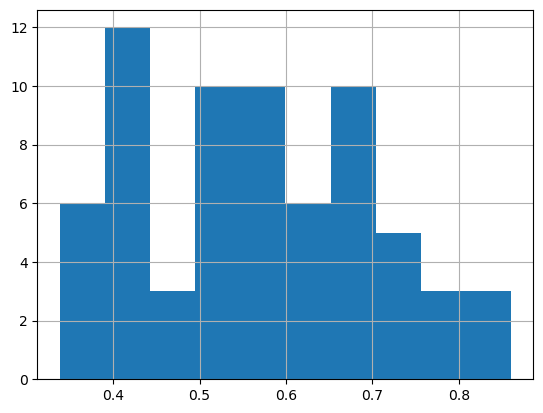

In [16]:
blr_metrics['SMSE'].hist()
plt.show()

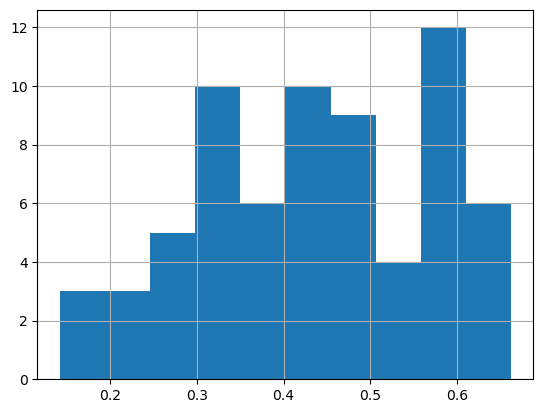

In [17]:
blr_metrics['EV'].hist()
plt.show()

In [ ]:
blr_metrics['MSLL'].hist()
plt.show()